In [1]:
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import os, sys
from math import floor

sys.path.append("code/")
from training import create_checkpoint_filename



INFO:numexpr.utils:Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
def load_linear(ts, y, start_day, end_day):
    y_shape=y.shape
    y_pred_linear = np.empty(y_shape)
        
    #loop over 4 timeslots in one day
    for offset in range(4):
        y_avv=np.mean(y[np.where(ts==start_day)[0][0]+offset:np.where(ts==end_day)[0][0]:4],axis=0)
        num_inserts=ts[offset:None:4].shape[0]
        y_pred_linear[offset:None:4,...]=np.repeat(y_avv[np.newaxis,:,:,:],num_inserts,axis=0)

    return y_pred_linear

In [3]:
def compute_skill(y, y_pred, ts):
    y_pred_ts=y_pred.view().reshape((y.shape[0], np.prod(y.shape[1:])))
    y_ts=y.view().reshape((y.shape[0], np.prod(y.shape[1:])))
    
    skill = 1-np.mean((y_pred_ts-y_ts)**2,axis=1)/np.mean((y_ts)**2,axis=1)
    return skill

In [4]:
#updates parameter tuple and resets the network
def increment_parameter_tuple(p_before):
  fn_before = create_checkpoint_filename(p_before)
  p_new=list(p_before)
  p_new[start_day_postion_in_the_list]=p_new[start_day_postion_in_the_list]+training_step_length
  p_new=tuple(p_new)
  fn_new = create_checkpoint_filename(p_new)
  return p_new


In [5]:
def moveav(data, window_length=3):
    tmp1=np.convolve(data, np.ones(window_length), 'same') 
    tmp2 = np.convolve(np.ones(len(data)), np.ones(window_length), 'same')
    tmp = tmp1/tmp2
    return tmp

In [15]:
#load skills
def load_skills(param_list,ts,number_of_training_steps,wds,rdir):
    skills = np.empty((len(ts), number_of_training_steps, len(wds)))

    ptmp=list(param_list[0])
    ptmp[start_day_postion_in_the_list]=starting_step
    ptmp=tuple(ptmp)
    for step in range(number_of_training_steps):
        param_list_new=[]
        for w in range(len(wds)):
            ptmp=param_list[w]
            fntmp1 = create_checkpoint_filename(ptmp)
            fntmp2 = os.path.join(rdir,'expvar_'+os.path.split(fntmp1)[-1]+'.npy')
            skills[:, step, w]=np.load(fntmp2)

            #increment parameter tuple in time
            param_list_new.append( increment_parameter_tuple(ptmp) )
        param_list=param_list_new
    return skills


In [27]:
def smooth_weeks12_skils(skills,ts,training_step_length):
    number_of_training_steps=skills.shape[1]
    
    ts_step=np.empty((number_of_training_steps,2,))
    ts_step[:]=np.nan
    skill_step=np.empty((number_of_training_steps,2,))
    skill_step[:]=np.nan
    
    for step in range(number_of_training_steps):
        start=starting_step+(training_step_length*step)+0.25
    
        idx_test=np.where( (ts>=start+training_step_length) & (ts<(start+training_step_length+14)) )
        ts_step[step,0]=np.nanmean(ts[idx_test])
        if len(idx_test[0])>1:
            skill_step[step,0] = np.nanmean(np.ndarray.flatten(skills[idx_test[0],step,0]))
                        
        idx_test=np.where( (ts>=start+training_step_length+14) & (ts<(start+training_step_length+28)) )
        ts_step[step,1]=np.nanmean(ts[idx_test])
        if len(idx_test[0])>1:
            skill_step[step,1] = np.nanmean(np.ndarray.flatten(skills[idx_test[0],step,0]))
    return ts_step, skill_step


In [7]:
#paramenter block 
varn='t'


In [8]:
#load truth
y = np.load('npys/y_conv2d_tpsuvq_online_'+varn+'.npy')
ts = np.arange(y.shape[0])/4

In [9]:
#compute linear baseline
y_pred_linear = load_linear(ts, y, 10, 375)
skill_linear = compute_skill(y, y_pred_linear, ts)

In [10]:
#load nn trained with 365 days
y_pred_nn = np.load('npys_365/ypred_conv2d_tpsuvq_online_'+varn+'_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_365_0.7.npy')
skill_nn365 = compute_skill(y, y_pred_nn, ts)

In [38]:
#First experiment 
training_step_length=7
start_day_postion_in_the_list=-3
starting_step = 14
number_of_training_steps = 65
number_of_training_steps = floor((455-starting_step)/training_step_length)
wds=[1e-6]
rdir='npys'

#create parameter tuples
wds_postion_in_the_list = -5
p=list(('tpsuvq', 'online', 't', 4, '1', '4096', 3, 0.25, 8, 'wnew', 0.0001, wds[0], 'sub', starting_step, 14, 0.7))
param_list=[]
for w in wds:
  p[wds_postion_in_the_list]=w
  param_list.append(tuple(p))

skills_1 = load_skills(param_list,ts,number_of_training_steps,wds,'npys')
ts_step_1, smooth_skills_1=smooth_weeks12_skils(skills_1,ts,training_step_length)

/tmp/ipykernel_22632/3032275483.py:18: RuntimeWarning: Mean of empty slice
  ts_step[step,1]=np.nanmean(ts[idx_test])


In [29]:
#second experiment 
training_step_length=7
start_day_postion_in_the_list=-3
starting_step = 14
number_of_training_steps = 65
wds=[1]
rdir='npys_w_old'

#create parameter tuples
wds_postion_in_the_list = -5
p=list(('tpsuvq', 'online', 't', 4, '1', '4096', 3, 0.25, 8, 'mse', 0.0001, wds[0], 'sub', starting_step, 14, 0.7))
param_list=[]
for w in wds:
  p[wds_postion_in_the_list]=w
  param_list.append(tuple(p))

skills_2 = load_skills(param_list,ts,number_of_training_steps,wds,rdir)
ts_step_2, smooth_skills_2=smooth_weeks12_skils(skills_2,ts,training_step_length)

/tmp/ipykernel_22632/3032275483.py:18: RuntimeWarning: Mean of empty slice
  ts_step[step,1]=np.nanmean(ts[idx_test])
/tmp/ipykernel_22632/3032275483.py:13: RuntimeWarning: Mean of empty slice
  ts_step[step,0]=np.nanmean(ts[idx_test])


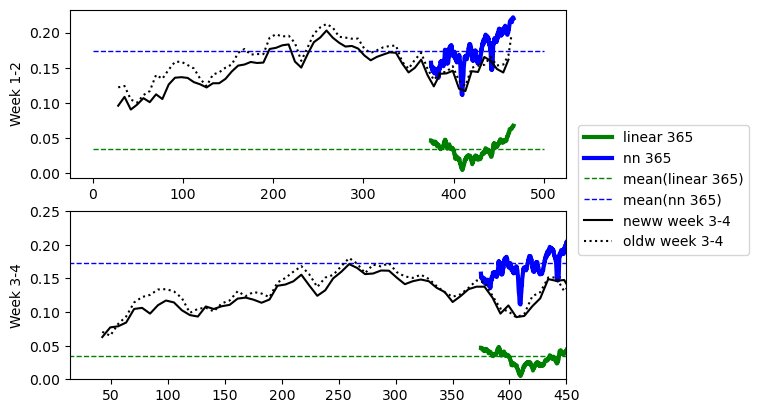

In [51]:
smooth=9

fig, ax = plt.subplots(2,1)

#week 1-2
idx_test=np.where( (ts>=375) )
ax[0].plot(ts[idx_test], moveav(skill_linear[idx_test],smooth), color='g',linewidth=3, label='linear 365')
ax[0].plot(ts[idx_test], moveav(skill_nn365[idx_test],smooth), color='b',linewidth=3, label='nn 365')
ax[0].plot([0, 500], np.mean(skill_linear[idx_test])*np.array([1, 1]), 'g--',linewidth=1, label='mean(linear 365)')
ax[0].plot([0, 500], np.mean(skill_nn365[idx_test])*np.array([1, 1]), 'b--',linewidth=1, label='mean(nn 365)')
ax[0].plot(ts_step_1[:,0], smooth_skills_1[:,0], 'k', label='neww week 1-2')
ax[0].plot(ts_step_2[:,0], smooth_skills_2[:,0], 'k:', label='oldw week 1-2')
ax[0].set_ylabel('Week 1-2')

ax[1].plot(ts[idx_test], moveav(skill_linear[idx_test],smooth), color='g',linewidth=3, label='linear 365')
ax[1].plot(ts[idx_test], moveav(skill_nn365[idx_test],smooth), color='b',linewidth=3, label='nn 365')
ax[1].plot([0, 500], np.mean(skill_linear[idx_test])*np.array([1, 1]), 'g--',linewidth=1, label='mean(linear 365)')
ax[1].plot([0, 500], np.mean(skill_nn365[idx_test])*np.array([1, 1]), 'b--',linewidth=1, label='mean(nn 365)')
ax[1].plot(ts_step_1[:,1], smooth_skills_1[:,1], 'k', label='neww week 3-4')
ax[1].plot(ts_step_2[:,1], smooth_skills_2[:,1], 'k:', label='oldw week 3-4')
ax[1].set_ylabel('Week 3-4')
ax[1].set_ylim(0,0.25)
ax[1].set_xlim(14,450)
ax[1].legend(bbox_to_anchor=(1.01, 0.7))
